In [482]:
import numpy as np
import modern_robotics as mr
import matplotlib.pyplot as plt
import math as m

In [483]:
#Define constants

#Initial configurations
Tbo = np.array([[1, 0, 0, 0.1662],
                [0, 1, 0, 0],
                [0, 0, 1, 0.0026],
                [0, 0, 0, 1]])
Moe = np.array([[1, 0, 0, 0.033],
                [0, 1, 0, 0],
                [0, 0, 1, 0.6546],
                [0, 0, 0, 1]])

#Blist
B = np.array([[0, 0, 1, 0, 0.033, 0],
             [0, -1, 0, -0.5076, 0, 0],
             [0, -1, 0, -0.3526, 0, 0],
             [0, -1, 0, -0.2176, 0, 0],
             [0, 0, 1, 0, 0, 0]]).T

#Initial cube configuration and final cube configuration
Tsc_initial = np.array([[1, 0, 0, 1],
                        [0, 1, 0, 0],
                        [0, 0, 1, 0.025],
                        [0, 0, 0, 1]])

Tsc_goal = np.array([[0, 1, 0, 0],
                        [-1, 0, 0, -1],
                        [0, 0, 1, 0.025],
                        [0, 0, 0, 1]])

#robot dimensions
l = 0.47/2
w = 0.3/2
r = 0.0475
H = 1/r * np.array([[-l-w, 1, -1],
                   [l+w, 1, 1],
                   [l+w, 1, -1],
                   [-l-w, 1, 1]])
F = np.linalg.pinv(H)
F6 = np.zeros((6,4))
F6[2:5, :] = F

joint_speed_limit = 6 #rad/s
wheel_speed_limit = 1 #m/s

print('Defined constants and speed limits')

Defined constants and speed limits


In [484]:
def enforce_speed_limits(controls):
    """Function to enforce speed limits"""
    #controls: [u1, u2, u3, u4, vj1, vj2, vj3, vj4, vj5]
    for i in range(len(controls)):
        if i < 4 and abs(controls[i]) > wheel_speed_limit:
            controls[i] = controls[i]/abs(controls[i]) * wheel_speed_limit
        if i >=4 and abs(controls[i]) > joint_speed_limit:
            controls[i] = controls[i]/abs(controls[i]) * joint_speed_limit
    
    return controls

def next_state(config, controls, dt):

    """Function to find next config given current config, controls and dt"""

    #config : [phi, x, y, j1, j2, j3, j4, j5, w1, w2, w3, w4, ]
    #controls: [u1, u2, u3, u4, vj1, vj2, vj3, vj4, vj5]

    controls = enforce_speed_limits(controls)

    #update wheel angles and joint angles
    wheel_change = controls[0:4]*dt
    joint_change = controls[4:9]*dt
    config[3:8] += joint_change
    config[8:12] += wheel_change

    #odometry
    Vb = F @ np.reshape(wheel_change, (4,1))
    wz, vx, vy = Vb[0][0], Vb[1][0], Vb[2][0]
    
    if wz < 1e-9:

        dconfig = np.array([0, vx, vy]).T
    else:
        dconfig = np.array([wz, 1/wz * (vx*m.sin(wz) + vy*(m.cos(wz)-1)), 1/wz * (vy*m.sin(wz) + vy*(1-m.cos(wz)))]).T

    dconfig = np.array([[1, 0, 0],
                  [0, m.cos(config[0]), -m.sin(config[0])], 
                  [0, m.sin(config[0]), m.cos(config[0])]]) @ dconfig
    
    #update configuration
    config[0:3] += np.reshape(dconfig, (3,))

    return config

print('Next_state function ready')

Next_state function ready


In [485]:
def toe_from_angles(joint_angles):
    """Function to find Transformation to end-effector frame wrt arm base"""

    Toe = Moe
    for i in range(len(joint_angles)):
        Toe = Toe @ mr.MatrixExp6(joint_angles[i] * mr.VecTose3(B[:, i]))
    
    return Toe

def traj_to_config(traj, grip):
    ret = []
    for trj in traj:

        R = trj[:3, :3]
        p = trj[:3, 3]
        ret.append(np.hstack((R.flatten(), p.flatten(), np.array([grip]))))
    
    return np.array(ret)

k = 1
#Initial reference configuration
init_ref_config = np.array([0, 0, 0 , 0, -0.7, -1.7, 0.5, 0, 0, 0, 0, 0])
phi_init = init_ref_config[0]

#Initial Transformation matrix for chassis
Tsb_initial = np.array([[m.cos(phi_init), -m.sin(phi_init), 0, init_ref_config[1]],
                        [m.sin(phi_init), m.cos(phi_init), 0, init_ref_config[2]],
                        [0, 0, 1, 0.0963],
                        [0, 0, 0, 1]])

#Initial end-effector configuration
Tse_initial = Tsb_initial @ Tbo @ toe_from_angles(init_ref_config[3:8])

#Standoff and grasp configurations
phi_standoff = 90
Tce_standoff = np.array([[m.cos(phi_standoff), 0, m.sin(phi_standoff), 0],
                         [0, 1, 0, 0],
                         [-m.sin(phi_standoff), 0, m.cos(phi_standoff), 0.06],
                         [0, 0, 0, 1]])
Tce_grasp = np.array([[m.cos(phi_standoff), 0, m.sin(phi_standoff), 0],
                         [0, 1, 0, 0],
                         [-m.sin(phi_standoff), 0, m.cos(phi_standoff), 0],
                         [0, 0, 0, 1]])


#Segment1 initial -> standoff
t1 = 30
traj1 = traj_to_config(mr.CartesianTrajectory(Tse_initial, Tsc_initial @ Tce_standoff, t1, t1*k/0.01, 3), 0)


#Segment2 standoff -> grasp
t2 = 10
traj2 = traj_to_config(mr.CartesianTrajectory(Tsc_initial @ Tce_standoff, Tsc_initial @ Tce_grasp, t2, t2*k/0.01, 3), 0)

#Segment3 closing gripper
t3 = 10
arr = np.hstack(((Tsc_initial @ Tce_grasp)[:3, :3].flatten(),(Tsc_initial @ Tce_grasp)[:3, 3].flatten(), np.array([1])))
traj3 = np.array([arr for i in range(63)])

#Segment4 grasp -> standoff 
t4 = 10
traj4 = traj_to_config(mr.CartesianTrajectory(Tsc_initial @ Tce_grasp, Tsc_initial @ Tce_standoff, t4, t3*k/0.01, 3), 1)

#Segment5 standoff -> final_standoff
t5 = 50
traj5 = traj_to_config(mr.CartesianTrajectory(Tsc_initial @ Tce_standoff, Tsc_goal @ Tce_standoff, t5, t5*k/0.01, 3), 1)

#Segment6 final_standoff -> dropoff
t6 = 10
traj6 = traj_to_config(mr.CartesianTrajectory(Tsc_goal @ Tce_standoff, Tsc_goal @ Tce_grasp, t6, t6*k/0.01, 3), 1)

#Segment7 release gripper
t7 = 10
arr = np.hstack(((Tsc_goal @ Tce_grasp)[:3, :3].flatten(),(Tsc_goal @ Tce_grasp)[:3, 3].flatten(), np.array([0])))
traj7 = np.array([arr for i in range(63)])

#Segment8 dropoff -> final_standoff
t8 = 10
traj8 = traj_to_config(mr.CartesianTrajectory(Tsc_goal @ Tce_grasp, Tsc_goal @ Tce_standoff, t8, t8*k/0.01, 3), 0)

ref_traj = np.vstack((traj1, traj2, traj3, traj4, traj5, traj6, traj7, traj8))
# print(len(ref_traj))

print('Generated and saved reference trajectory')
np.savetxt('reference_trajectory.csv', ref_traj, delimiter=',', fmt='%.6f')


Generated and saved reference trajectory


In [486]:
def x_from_config(config):
    """Function to find end-effector transformation matrix in space frame using robot configuration"""
    phi, x, y = config[0:3]
    joint_angles = config[3:8]

    Tsb = np.array([[m.cos(phi), -m.sin(phi), 0, x],
                        [m.sin(phi), m.cos(phi), 0, y],
                        [0, 0, 1, 0.0963],
                        [0, 0, 0, 1]])
    
    Toe = toe_from_angles(joint_angles)

    return Tsb @ Tbo @ Toe

def feedforward_control(X, Xd, Xd_next, Kp, Ki, dt, Ki_err, config):
    
    """Function to implement feedforward control with velocity inputs"""
    Xerr = np.reshape(mr.se3ToVec(mr.MatrixLog6(np.linalg.inv(X) @ Xd)), (6,1))
    Vd = np.reshape(mr.se3ToVec(1/dt * mr.MatrixLog6(np.linalg.inv(Xd) @ Xd_next)), (6,1))
    Ki_err += Xerr*dt

    V = mr.Adjoint(np.linalg.inv(X)@Xd) @ Vd + Kp @ Xerr + Ki @ Ki_err

    J_arm = mr.JacobianBody(B, config[3:8])

    Toe = mr.FKinBody(Moe, B, config[3:8])
    J_base = mr.Adjoint(np.linalg.inv(Toe) @ np.linalg.inv(Tbo)) @ F6
    J = np.hstack((J_base, J_arm))

    controls = np.linalg.pinv(J)@V

    return controls.flatten(), Xerr, Ki_err

print('Feed Forward control function ready')

Feed Forward control function ready


In [487]:
def x_from_ref_traj(line):
    """Function to construct end-effector transformation matrix from reference_trajectory lines saved in csv files"""
    R = np.reshape(line[0:9], (3,3))
    p = np.reshape(line[9:12], (3,1))

    return np.vstack((np.hstack((R, p)),np.array([0, 0, 0, 1])))

#initial configuration for simulation
config = np.array([0.2, 0.05, 0.05 , 0, -0.17, -1.57, 0.45, 0, 0, 0, 0, 0, 0])

#Controller gains
Kp = 1*np.array([[1, 0, 0, 0, 0, 0],
               [0, 1, 0, 0, 0, 0],
               [0, 0, 1, 0, 0, 0],
               [0, 0, 0, 1, 0, 0],
               [0, 0, 0, 0, 1, 0],
               [0, 0, 0, 0, 0, 1]])

Ki = 1*np.array([[1, 0, 0, 0, 0, 0],
               [0, 1, 0, 0, 0, 0],
               [0, 0, 1, 0, 0, 0],
               [0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0]])

Ki_err = np.zeros((6,1))
dt = 0.01

#Lists to keep track of states
config_list = [config.copy()]
error_list = []
controls_list = []

print("Starting simulation")

for i in range(len(ref_traj)-1):
    
    #load lines from ref_traj
    l1, l2 = ref_traj[i], ref_traj[i+1]

    #make corresponding transformation matrices
    Xd, Xd_next = x_from_ref_traj(l1), x_from_ref_traj(l2)

    #Call feedforward_control to obtain controls and errors
    controls, Xerr, Ki_err = feedforward_control(x_from_config(config), Xd, Xd_next, Kp, Ki, dt, Ki_err, config)

    #update config using obtained controls
    config = next_state(config, controls, dt)

    #update gripper state to be next_desired_state's same value
    config[-1] = l2[-1]

    #Store states in lists
    config_list.append(config.copy())
    error_list.append(Xerr.flatten().copy())
    controls_list.append(controls.copy())

#Save results
print("Saving results")
np.savetxt('x.csv', np.array(config_list),  delimiter=',', fmt='%.6f')
np.savetxt('err.csv', np.array(error_list),  delimiter=',', fmt='%.6f')

Starting simulation
Saving results


In [488]:
def plot_columns(data, labels):
    """
    Plots each column of a 2D numpy array as separate plots in a grid layout.

    Parameters:
    data (numpy.ndarray): 2D array where each column is a data series to be plotted.
    labels (list): List of labels for each data series (column).
    """
    if data.shape[1] != len(labels):
        raise ValueError("Number of columns in data must match number of labels")

    # Determine the number of rows and columns for the grid
    num_plots = data.shape[1]
    num_cols = 3  # Number of columns in the grid
    num_rows = int(np.ceil(num_plots / num_cols))  # Calculate the required number of rows
    
    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows))
    axes = axes.flatten()  # Flatten the axes array to easily iterate over

    # Plot each column in a separate subplot
    for i in range(num_plots):
        axes[i].plot(data[:, i])
        axes[i].set_title(labels[i])
        axes[i].set_xlabel("Iterations")
        axes[i].set_ylabel("Values")

    # Hide any unused subplots
    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])

    # Adjust layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()

print("Plotting results")

Plotting results


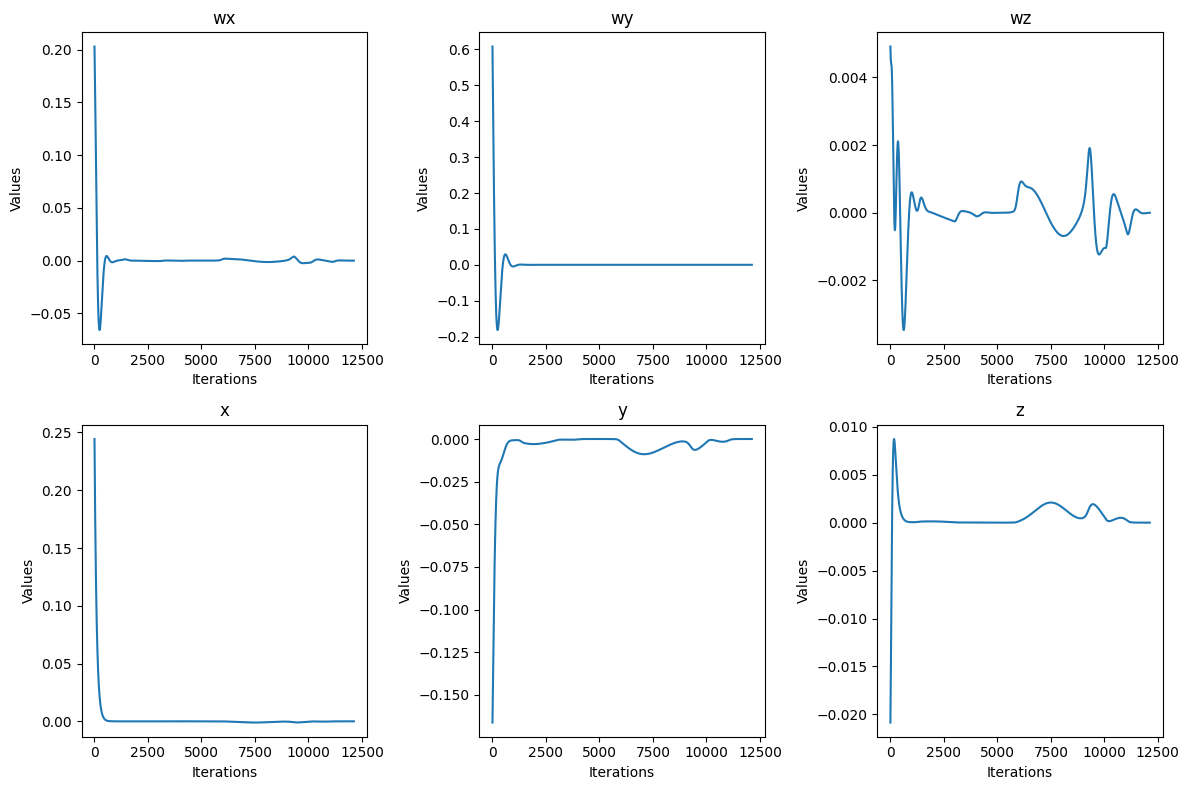

In [489]:
err_labels = ['wx', 'wy', 'wz', 'x', 'y', 'z']
plot_columns(np.array(error_list), err_labels)

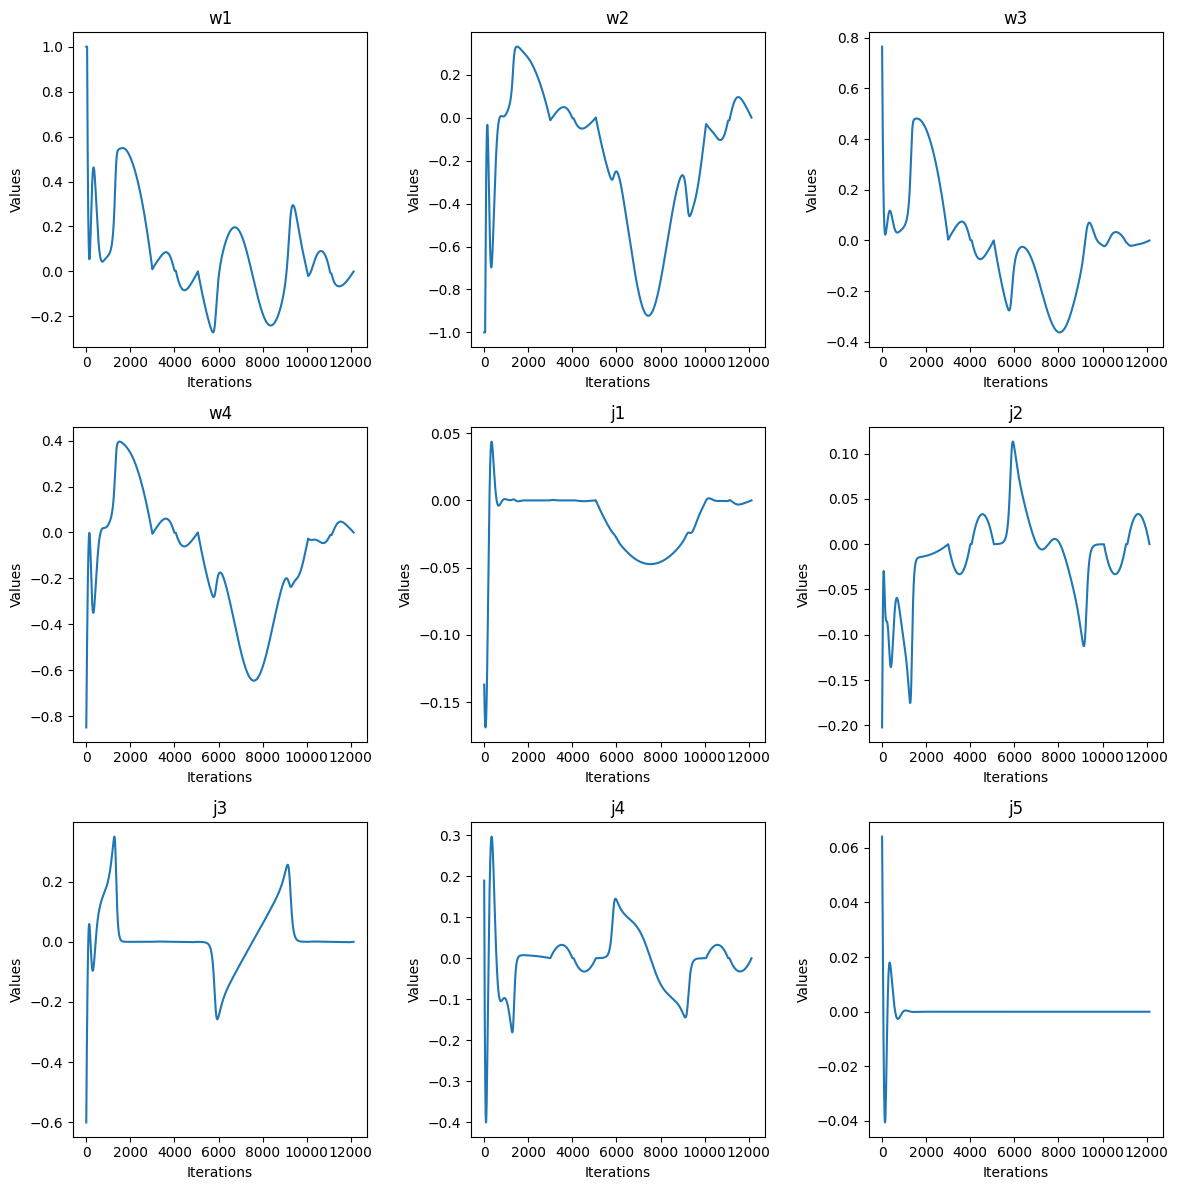

In [490]:
control_labels = ['w1', 'w2', 'w3', 'w4', 'j1', 'j2', 'j3', 'j4', 'j5']
plot_columns(np.array(controls_list), control_labels)